# High(-est) Fidelity Extraction of a Linear Model

***Note: I'm running in this in Google Colab.***
In this notebook, we will walk through a simple tutorial for stealing a linear model assuming that the attacker knows the model architecture and has query access to the victim model. This isn't really practical because most sensitive and deployed ML models are non-linear and deep,  but it's a good starting point to gain some intuition on how to cleverly extract the parameters of a model. This notebook is based off of the following paper: High Accuracy and High Fidelity Extraction of Neural Networks (Matthew Jagielski, Nicholas Carlini, David Berthelot, Alex Kurakin, Nicolas Papernot @ USENIX 2020). 

- [paper](https://arxiv.org/abs/1909.01838)
- [talk](https://youtu.be/PPU2a_A2ScI)

In particular, we will extract a **functionally equivalent linear model**. Recall that a functionally equivalent extracted model behaves *precisely* as the victim model behaves across the entire input space. 
## 1. Imports
Let's import some libraries. We will be using `jax` as our main library. You may find the following tutorials helpful. Much of the jax code in this tutorial came from the first reference below:

- [Jax - Linear Regression](https://coax.readthedocs.io/en/latest/examples/linear_regression/jax.html)
- [Jax - The Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)

In [ ]:
import jax                                            # jax
import jax.numpy as jnp                               # numpy from jax
from sklearn.datasets import make_regression          # building a simple dataset
from sklearn.model_selection import train_test_split  # splitting train and test

from tqdm import tqdm                                 # progress bar
import matplotlib.pyplot as plt                       # plotting library

## 2. Creating the dataset
Let's create a regression dataset of 10,000 samples. Let's also control the feature size. 

In [ ]:
INPUT_DIM = 10

In [ ]:
X, y = make_regression(n_samples=1000, n_features=INPUT_DIM)    # create dataset
x_train, x_test, y_train, y_test = train_test_split(X, y)       # split dataset
train_mean = jnp.mean(x_train, axis=0, keepdims=True)           # train mean
train_std  = jnp.std(x_train, axis=0, keepdims=True)            # train std
x_train = (x_train - train_mean) / train_std                    # norm. train
x_test  = (x_test - train_mean) / train_std                     # norm. test
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(750, 10) (250, 10) (750,) (250,)


So, we have now have a train and test dataset. The first axis corresponds to the batch while the second axis are the actual features. We've also normalized the dataset using standard practices.

## 3. Creating a simple linear model

We will create a $d$-dimensional linear model. That means our function maps $d$-dimensional vectors to a real value ($\mathrm{R}^d \rightarrow \mathrm{R}$). `jax` **explicitly** handles randomness so let's generate a key and sample some weights for our linear model. 

In [ ]:
# model weights
key = jax.random.PRNGKey(0)
params = {
    'w': jax.random.normal(key, shape=(x_train.shape[1],)),  # weights
    'b': jnp.array([0.])                                     # bias
}
print(params)

{'w': DeviceArray([-0.372111  ,  0.26423106, -0.18252774, -0.7368198 ,
             -0.44030386, -0.15214427, -0.6713536 , -0.5908642 ,
              0.73168874,  0.5673025 ], dtype=float32), 'b': DeviceArray([0.], dtype=float32)}


## 4. Creating the forward pass, loss function, and update rule.

In [ ]:
def forward(params, X):
  return jnp.dot(X, params['w']) + params['b']

def loss_fn(params, X, y):
  err = forward(params, X) - y
  return jnp.mean(jnp.square(err))  

# autodiff allows us to differeniate a function w.r.t its inputs (by default, the first argument)
value_grad_fn = jax.value_and_grad(loss_fn) 

def update(params, grads, learning_rate):
    return jax.tree_multimap(lambda p, g: p - learning_rate * g, params, grads)

## 5. Training this model
Now, we take the position of the victim. We have our collected dataset and a model which we'd like to train. Again, we aren't looking for a fancy model or high accuracy here; we are just simulating the process of some organization creating a (linear) model. It won't take long at all to train this simple linear model.

In [ ]:
NUM_EPOCHS=100
learning_rate = 3e-1
train_losses = []
test_losses  = []
for epoch in tqdm(range(NUM_EPOCHS)):
    loss = loss_fn(params, x_test, y_test)
    test_losses.append(loss)

    loss, grads = value_grad_fn(params, x_train, y_train) 
    train_losses.append(loss)
    params = update(params, grads, learning_rate)

100%|██████████| 100/100 [00:02<00:00, 42.91it/s]


## 6. Plotting metrics
Let's go ahead and plot our train and val loss curves. Again, these aren't that important for our task, but it's good to check that training proceded correctly.

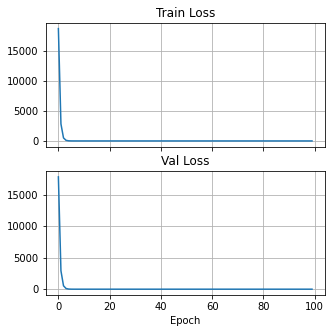

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5), sharex=True)
ax[0].plot(train_losses)
ax[0].set_title("Train Loss")
ax[0].grid()
ax[1].plot(test_losses)
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch");
ax[1].grid();

In [ ]:
params

{'b': DeviceArray([-0.12844068], dtype=float32),
 'w': DeviceArray([59.207184 , 21.589506 , 44.023746 , 71.02374  , 29.497866 ,
              39.228783 , 26.272846 , 24.236612 , 60.160286 ,  4.2438154],            dtype=float32)}

## 7. Functionally-Equivalent Model Extraction
Now, let's assume that we are some malicious party that wants to steal the trained linear model. We have the following:

- Access to the model architecture (but crucially, not the parameters!)
- Query access (we can provide an input to the victim's model and observe the real-valued output)

One obvious method would be to generate many input and output pairs and train a proxy model. **However, in this notebook, we will look at a more *surgical* approach to stealing a functionally-equivalent model.**

In particular, we know that our model assumes the following form:
$$ f(x) = w^Tx + b$$
where $w, x \in \mathrm{R}^d$ and $b \in \mathrm{R}^1$. First, we can immediately see that querying the model at $\vec{x}=0$ will provide us with the bias (you can confirm this by looking at the `forward` function). Second, by passing in the [canonical basis vectors](https://en.wikipedia.org/wiki/Standard_basis), we will in return receive $w_i + b \text{ } \forall i \in \{1..d\}$. Let's build these queries and steal the model.

In [ ]:
QUERY_WEIGHT = jnp.eye(INPUT_DIM)       #  canonical basis vectors as a single batch
QUERY_BIAS   = jnp.zeros((1,INPUT_DIM)) #  zero vector to retreive the bias()

Let's go ahead and print these:

In [ ]:
print(QUERY_WEIGHT); print(); print(QUERY_BIAS)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print(QUERY_WEIGHT.shape, QUERY_BIAS.shape)

(10, 10) (1, 10)


## 8. Querying the victim model
Now that we have prepared our queries, let's query the victim model and see if we can extract a functionally-equivalent model. 

In [ ]:
out_w = forward(params, QUERY_WEIGHT)
out_b = forward(params, QUERY_BIAS)

In [ ]:
print(out_w.shape, out_b.shape, params['w'].shape, params['b'].shape)

(10,) (1,) (10,) (1,)


## 9. Extracting the weights and bias of the linear model. 

Recall that our first query extracted $w_i + b$. Thus, to extract the exact weights, we just need to subtract the bias from each query that used the basis vectors. 

In [ ]:
jnp.all(jnp.isclose(params['w'], (out_w - out_b)))

DeviceArray(True, dtype=bool)

Great, so now we have the weights of the linear model. The bias is trivial since we passed in the zero vector and received the bias directly from the victim model. Let's just confirm:

In [ ]:
jnp.all(jnp.isclose(params['b'], out_b))

DeviceArray(True, dtype=bool)

Now, we have effectively stolen the linear model that the victim trained! As a malicious actor, we can now build our own functionally equivalent model. Let's ensure the models have the exact same output for some random datapoint.

In [ ]:
functionally_equivalent_params = {
    'w': out_w - out_b,  # stolen weights
    'b': out_b           # stolen bias
}

key = jax.random.PRNGKey(10) # notice that without updating the random state, jax.random returns the same values for arrays of the same shape
print(forward(params, jax.random.normal(key, shape=(INPUT_DIM,))))
print(forward(functionally_equivalent_params, jax.random.normal(key, shape=(INPUT_DIM,))))

[56.26381]
[56.26381]


So how many queries did it take us to steal the victim model? We batched up our canonical vectors and had one additional query to obtain the bias. 

In [ ]:
print("Functionally Equivalent Linear Model generated with {} queries.".format(QUERY_WEIGHT.shape[0] + QUERY_BIAS.shape[0]))

Functionally Equivalent Linear Model generated with 11 queries.


Thus, we simply needed $d+1$ queries to the model in order to produce a functionally equivalent stolen model. While this is a rather simple example, it illustrates that having some information about the model architecture allows one to produce precise queries that can outmatch any standard method (e.g. machine-learning based) when trying to steal a victim model.